# Testing VGG Face for Face Similarity and Verification
I found [this great notebook](https://github.com/serengil/tensorflow-101/blob/master/python/vgg-face.ipynb) and tested it out. Including it in our examples.


In [1]:
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
import numpy as np
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
from skimage.io import imread

Using TensorFlow backend.
/home/mattmann/install/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mattmann/install/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mattmann/install/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mattmann/install/python

In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [4]:
#you can download the pretrained weights from the following link 
#https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
#or you can find the detailed documentation https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/

from keras.models import model_from_json
model.load_weights('vgg_face_weights.h5')

In [5]:
def preprocess_image(image_path):  
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #img = (1/(2*2.25)) * img + 0.5
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [6]:
def clean_image(image_path): 
    img = imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #img = (1/(2*2.25)) * img + 0.5
    return img

In [7]:
def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [8]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [11]:
epsilon = 0.40

def verifyFace(img1, img2):
    img1_representation = vgg_face_descriptor.predict(preprocess_image('vgg-face/%s' % (img1)))[0,:]
    img2_representation = vgg_face_descriptor.predict(preprocess_image('vgg-face/%s' % (img2)))[0,:]
    
    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
    
    print("Cosine similarity: ",cosine_similarity)
    print("Euclidean distance: ",euclidean_distance)
    
    if(cosine_similarity < epsilon):
        print("verified... they are same person")
    else:
        print("unverified! they are not same person!")
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(clean_image('vgg-face/%s' % (img1)))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(clean_image('vgg-face/%s' % (img2)))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    print("-----------------------------------------")

Cosine similarity:  0.16372257471084595
Euclidean distance:  100.18298
verified... they are same person


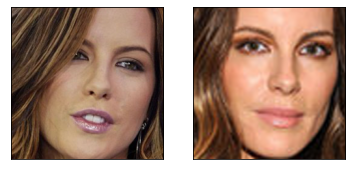

-----------------------------------------
Cosine similarity:  0.15653300285339355
Euclidean distance:  97.69178
verified... they are same person


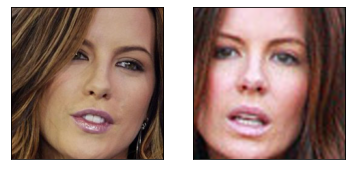

-----------------------------------------
Cosine similarity:  0.13598185777664185
Euclidean distance:  82.56545
verified... they are same person


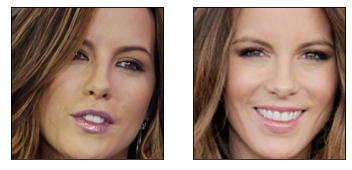

-----------------------------------------
Cosine similarity:  0.229050874710083
Euclidean distance:  99.04395
verified... they are same person


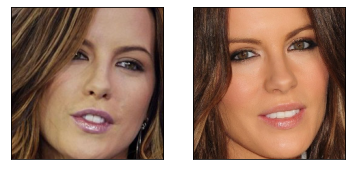

-----------------------------------------
Cosine similarity:  0.17853975296020508
Euclidean distance:  88.4975
verified... they are same person


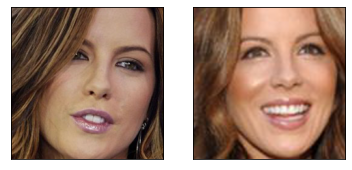

-----------------------------------------
Cosine similarity:  0.23021692037582397
Euclidean distance:  99.266235
verified... they are same person


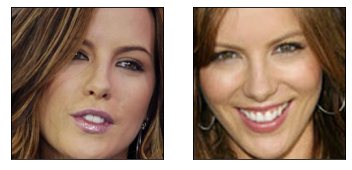

-----------------------------------------


In [12]:
verifyFace("Kate_Beckinsale/2_244x244.png", "Kate_Beckinsale/51_244x244.png")
verifyFace("Kate_Beckinsale/2_244x244.png", "Kate_Beckinsale/52_244x244.png")
verifyFace("Kate_Beckinsale/2_244x244.png", "Kate_Beckinsale/53_244x244.png")
verifyFace("Kate_Beckinsale/2_244x244.png", "Kate_Beckinsale/54_244x244.png")
verifyFace("Kate_Beckinsale/2_244x244.png", "Kate_Beckinsale/56_244x244.png")
verifyFace("Kate_Beckinsale/2_244x244.png", "Kate_Beckinsale/57_244x244.png")

Cosine similarity:  0.6325984299182892
Euclidean distance:  170.6367
unverified! they are not same person!


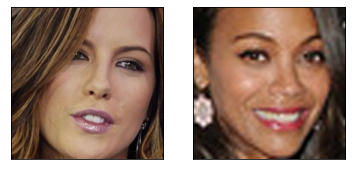

-----------------------------------------
Cosine similarity:  0.686864048242569
Euclidean distance:  162.34074
unverified! they are not same person!


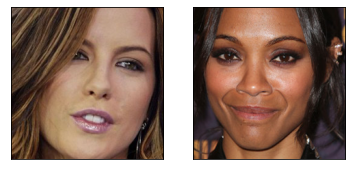

-----------------------------------------
Cosine similarity:  0.7287036776542664
Euclidean distance:  192.76741
unverified! they are not same person!


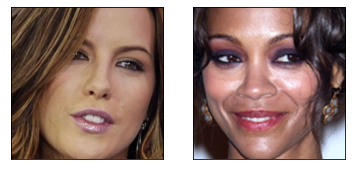

-----------------------------------------
Cosine similarity:  0.6606151759624481
Euclidean distance:  188.67113
unverified! they are not same person!


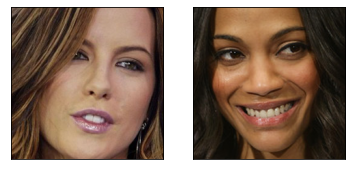

-----------------------------------------
Cosine similarity:  0.7948604375123978
Euclidean distance:  166.72212
unverified! they are not same person!


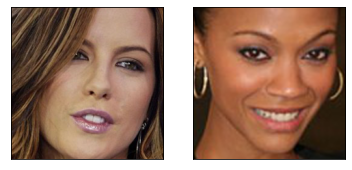

-----------------------------------------
Cosine similarity:  0.7088668644428253
Euclidean distance:  176.4569
unverified! they are not same person!


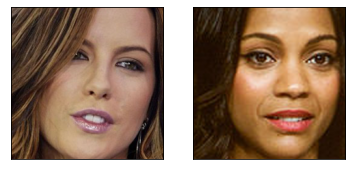

-----------------------------------------


In [13]:
verifyFace("Kate_Beckinsale/2_244x244.png", "Zoe_Saldana/332_244x244.png")
verifyFace("Kate_Beckinsale/2_244x244.png", "Zoe_Saldana/333_244x244.png")
verifyFace("Kate_Beckinsale/2_244x244.png", "Zoe_Saldana/334_244x244.png")
verifyFace("Kate_Beckinsale/2_244x244.png", "Zoe_Saldana/335_244x244.png")
verifyFace("Kate_Beckinsale/2_244x244.png", "Zoe_Saldana/336_244x244.png")
verifyFace("Kate_Beckinsale/2_244x244.png", "Zoe_Saldana/339_244x244.png")

Cosine similarity:  0.051710546016693115
Euclidean distance:  43.283745
verified... they are same person


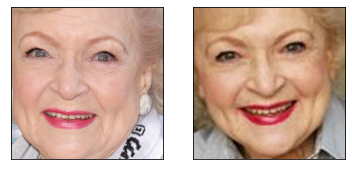

-----------------------------------------
Cosine similarity:  0.04703480005264282
Euclidean distance:  36.62127
verified... they are same person


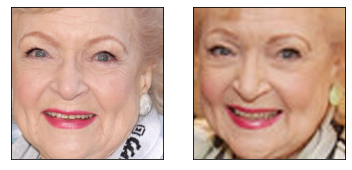

-----------------------------------------
Cosine similarity:  0.04824143648147583
Euclidean distance:  39.0568
verified... they are same person


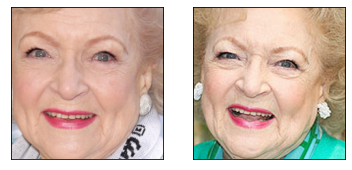

-----------------------------------------
Cosine similarity:  0.027182936668395996
Euclidean distance:  27.258642
verified... they are same person


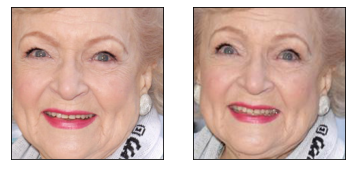

-----------------------------------------


In [14]:
verifyFace("Betty_White/8_244x244.png", "Betty_White/9_244x244.png")
verifyFace("Betty_White/8_244x244.png", "Betty_White/10_244x244.png")
verifyFace("Betty_White/8_244x244.png", "Betty_White/11_244x244.png")
verifyFace("Betty_White/8_244x244.png", "Betty_White/12_244x244.png")